# Computational topology - Sensors

You are given a number of points on the sphere of radius 1. You should view them as sensors on the surface of the Earth.  The sensors are used to gather data and form a sensor network with parameters $r$ and $R$:
- each sensor gathers data from the surrounding area in the shape of a circle of radius $R$,
- each sensor can communicate with other sensors which are at most $r$ away.

Project goal:  Determine $r$ and $R$, so that
1. numbers $r$ and $R$ are as small as possible (that would decrease the cost of sensors),
2. the sensor network is connected (i.e.  the Vietoris-Rips graph is connected),
3. the sensor network covers the whole sphere (the Čech complex should be homotopy equivalent to the sphere, i.e.  the Euler characteristic of the Čech complex should be that of a sphere).

Furthermore, once the parameters $r$ and $R$ are established, the program should return a list of obsolete sensors, i.e.  sensors, whose removal would not change the desired properties 2. and 3. of the sensor network.

**Data**: The input data is a set of points on the sphere of radius 1.

**Results**: The result should be required parameter values $r$ and $R$.
Start with an estimate for $r$ and $R$ and keep optimizing the values. To generate the Čech complex you can use the MiniBall algorithm.

**Data generator**: You should also produce a distribution of 50 points on the sphere with parameters $r$ and $R$ as small as possible.

In [2]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import gudhi
import miniball
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import distance_matrix, SphericalVoronoi, geometric_slerp
from scipy.optimize import minimize
from itertools import chain, combinations

## The data

We were given $54$ points on a sphere.

In [3]:
with open('sensors.txt') as f:
    points = np.asarray([[float(p) for p in point.split(',')]
                         for point in f.read()[2:-3].split('},{')])
pprint(points)

array([[ 0.0740328 , -0.0669765 , -0.995004  ],
       [-0.0424728 , -0.0903481 , -0.995004  ],
       [ 0.49942   , -0.26344   , -0.825336  ],
       [ 0.520044  ,  0.219943  , -0.825336  ],
       [ 0.158841  ,  0.54184   , -0.825336  ],
       [-0.318986  ,  0.465907  , -0.825336  ],
       [-0.562607  ,  0.0478954 , -0.825336  ],
       [-0.393151  , -0.405282  , -0.825336  ],
       [ 0.0649644 , -0.560893  , -0.825336  ],
       [ 0.475382  , -0.304685  , -0.825336  ],
       [ 0.866629  , -0.207856  , -0.453596  ],
       [ 0.844371  ,  0.28511   , -0.453596  ],
       [ 0.563236  ,  0.690663  , -0.453596  ],
       [ 0.109417  ,  0.884465  , -0.453596  ],
       [-0.377948  ,  0.807097  , -0.453596  ],
       [-0.749438  ,  0.482279  , -0.453596  ],
       [-0.891156  ,  0.00959889, -0.453596  ],
       [-0.759652  , -0.466025  , -0.453596  ],
       [-0.395246  , -0.798769  , -0.453596  ],
       [ 0.0903402 , -0.886617  , -0.453596  ],
       [ 0.548228  , -0.702635  , -0.453

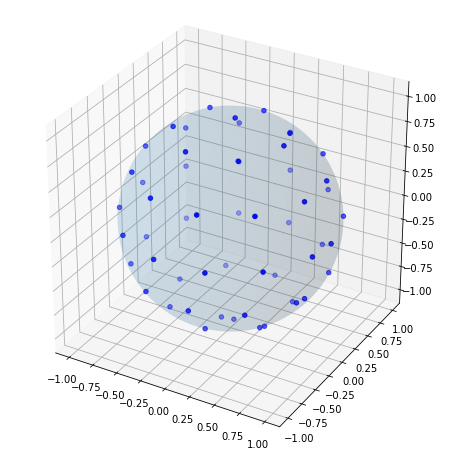

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
ax.plot_surface(np.outer(np.cos(u), np.sin(v)),
                np.outer(np.sin(u), np.sin(v)),
                np.outer(np.ones(np.size(u)), np.cos(v)),
                alpha=.1)

ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o')

plt.gca().set_aspect('equal')
plt.show()

## Computing the radii

The first options for computing the radii are to use:
- Spherical Voronoi diagram for coverage radius $R$.
- Persistent homology of Vietoris-Rips complex.

In [5]:
def compute_radii(points):
    # coverage
    sv = SphericalVoronoi(points)
    sv.sort_vertices_of_regions()
    R = max(distance_matrix(np.array([point]),
                            sv.vertices[sv.regions[i]]).max()
            for i, point in enumerate(sv.points))
    # connectivity
    diagram = ripser(points)['dgms'][0]
    r = diagram[diagram[:, 1] < float('inf')].max()
    return R, r

In [6]:
compute_radii(points)

(0.3621207618447775, 0.4965033233165741)

In [7]:
def find_obsolete(points):
    R, r = compute_radii(points)
    obsolete = []
    for i in range(len(points)):
        points_without = np.delete(points, i, axis=0)
        R_without, r_without = compute_radii(points_without)
        if np.allclose([R_without, r_without], [R, r]):
            obsolete.append(i)
    n = len(obsolete)
    if n > 1:
        obsolete_combinations = []
        for comb in chain.from_iterable(combinations(obsolete, i + 1) for i in range(n)):
            points_without = np.delete(points, comb, axis=0)
            R_without, r_without = compute_radii(points_without)
            if np.allclose([R_without, r_without], [R, r]):
                obsolete_combinations.append(comb)
        obsolete += obsolete_combinations
    return obsolete

In [8]:
find_obsolete(points)

[2]

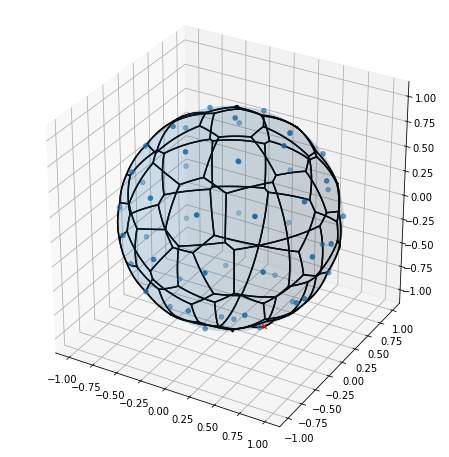

In [9]:
sv = SphericalVoronoi(points)
sv.sort_vertices_of_regions()
obs_arg = find_obsolete(points)
obsolete = points[obs_arg]
necessary = np.delete(points, obs_arg, axis=0)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
ax.plot_surface(np.outer(np.cos(u), np.sin(v)),
                np.outer(np.sin(u), np.sin(v)),
                np.outer(np.ones(np.size(u)), np.cos(v)),
                alpha=.1)

ax.scatter(necessary[:, 0],
           necessary[:, 1],
           necessary[:, 2])
ax.scatter(obsolete[:, 0],
           obsolete[:, 1],
           obsolete[:, 2],
           c='r', marker='x')

# ax.scatter(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2])

t = np.linspace(0, 1, 10)
for region in sv.regions:
    n = len(region)
    for i in range(n):
        start = sv.vertices[region][i]
        end = sv.vertices[region][(i + 1) % n]
        result = geometric_slerp(start, end, t)
        ax.plot(result[..., 0],
                result[..., 1],
                result[..., 2],
                c='k')

plt.gca().set_aspect('equal')
plt.show()

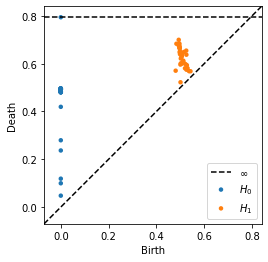

In [10]:
diagrams = ripser(points, maxdim=1)['dgms']
plot_diagrams(diagrams)

In [11]:
def generate_points(samples=50):
    z = np.linspace(-1, 1, samples)
    r = np.sqrt(1 - z**2)
    phi = np.pi * (np.sqrt(5.) - 1.) * np.arange(samples)
    x = np.cos(phi) * r
    y = np.sin(phi) * r
    return np.c_[x, y, z]

In [12]:
compute_radii(generate_points(50))

(0.3835176045327419, 0.4985489845275879)

## No persistent homology
Compute the radius for connectedness via bisection and Vietoris-Rips complex.

In [13]:
# Does a bisection to find the radius, not the best as complex is recomputed each time.

# def is_connected(points, radius=0.5):
#     """
#     Check if the Rips complex is connected.
#     Does so by counting unique vertices in 1-simplices (probably not the best way).
#     """
#     rips_complex = gudhi.RipsComplex(points=points, max_edge_length=radius)
#     simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)

#     dim1simplices = [simplex for simplex in simplex_tree.get_skeleton(1) if len(simplex[0]) == 2]
#     seen = set()
#     for simplex in dim1simplices:
#         seen.add(simplex[0][0])
#         seen.add(simplex[0][1])

#     return len(seen) == len(points)

def is_connected(points, radius):
    """
    check if Rips is connected via a depth-first search.
    """
    rips_complex = gudhi.RipsComplex(points=points, max_edge_length=radius)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)

    dim1simplices = [simplex for simplex in simplex_tree.get_skeleton(1) if len(simplex[0]) == 2]
    edges = {tuple(sorted(simplex[0])) for simplex in dim1simplices}

    def dfs(edges, start, visited=None):
        if visited is None:
            visited = set()
        visited.add(start)
        for edge in edges:
            if start in edge:
                other = edge[0] if edge[0] != start else edge[1]
                if other not in visited:
                    dfs(edges, other, visited)
        return visited

    return len(dfs(edges, 0)) == len(points)

def find_rips_radius(points, tolerance=1e-16):
    """
    Find the radius via bisecting the interval [0, 1].
    """
    left = 0
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if is_connected(points, radius=mid):
            right = mid
        else:
            left = mid
    return right

r = find_rips_radius(points)
r

0.4965033379263023

In [14]:
def find_obsolete_connectivity(points, radius):
    """
    Find the obsolete points (as far as connectivity is concerned).
    """
    obsolete = []
    for point in points:
        points_without = np.delete(points, np.where((points == point).all(axis=1))[0][0], axis=0)
        if is_connected(points_without, radius=radius):
            obsolete.append(point)

    return obsolete

find_obsolete_connectivity(points, r)

[array([-0.0424728, -0.0903481, -0.995004 ]),
 array([ 0.49942 , -0.26344 , -0.825336]),
 array([ 0.520044,  0.219943, -0.825336]),
 array([ 0.158841,  0.54184 , -0.825336]),
 array([-0.318986,  0.465907, -0.825336]),
 array([-0.562607 ,  0.0478954, -0.825336 ]),
 array([-0.393151, -0.405282, -0.825336]),
 array([ 0.866629, -0.207856, -0.453596]),
 array([ 0.844371,  0.28511 , -0.453596]),
 array([ 0.563236,  0.690663, -0.453596]),
 array([ 0.109417,  0.884465, -0.453596]),
 array([-0.377948,  0.807097, -0.453596]),
 array([-0.749438,  0.482279, -0.453596]),
 array([-0.891156  ,  0.00959889, -0.453596  ]),
 array([-0.759652, -0.466025, -0.453596]),
 array([-0.395246, -0.798769, -0.453596]),
 array([ 0.548228, -0.702635, -0.453596]),
 array([ 0.838034, -0.303231, -0.453596]),
 array([0.999467 , 0.0145951, 0.0291995]),
 array([0.870013 , 0.492164 , 0.0291995]),
 array([0.527371 , 0.849133 , 0.0291995]),
 array([0.0555024, 0.998031 , 0.0291995]),
 array([-0.429966 ,  0.902373 ,  0.0291995

## Čech complex
- Compute Čech complex of point set (using MiniBall algorithm).
- Use bisection to find covering radius.

[array([[0. , 0. ],
       [0.5, 0.5],
       [0. , 1. ]])]
15


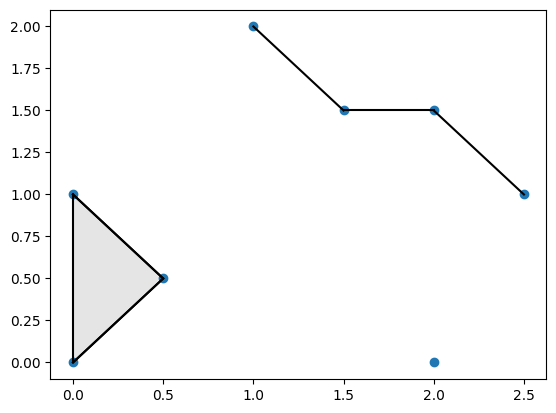

In [15]:
def powerset(points, max_size=3):
    """
    Compute the powerset of points.
    """
    return chain.from_iterable(combinations(points, r) for r in range(max_size, 0, -1))

def cech_complex(points, radius):
    """
    Compute the Cech complex.
    """
    cech_complex = []
    for subset in powerset(points):
        subset = np.array(subset)
        _, r = miniball.get_bounding_ball(subset)
        if r <= radius ** 2:
            cech_complex.append(subset)
        # if len(seen) == len(points):
        #     break

    return cech_complex

pts = np.array([[0, 0], [0.5, 0.5], [0, 1], [1, 2], [1.5, 1.5], [2, 1.5], [2.5, 1], [2, 0]])
ce = cech_complex(pts, 0.5)

print([simplex for simplex in ce if len(simplex) == 3])
print(len(ce))

plt.scatter(pts[:, 0], pts[:, 1])
for simplex in ce:
    plt.plot(simplex[:, 0], simplex[:, 1], c='k')
    if len(simplex) == 3:
        plt.fill(simplex[:, 0], simplex[:, 1], c='k', alpha=0.1)
plt.show()


In [16]:
# Precompute miniball radii for all (relevant) subsets of points.

def miniball_radii(points, max_size=3):
    """
    Compute the miniball radii for all subsets of points.
    """
    radii = {}
    for subset in powerset(points, max_size=max_size):
        subset = np.array(subset)
        _, r = miniball.get_bounding_ball(subset)
        radii[hash((str(subset)))] = r
    return radii

radii = miniball_radii(points, max_size=4)

In [17]:
# Bisection to find coverage radius.

def fast_cech_complex(points, radii, radius, max_size=3):
    """
    Compute the Cech complex.
    """
    cech_complex = []
    for subset in powerset(points, max_size=max_size):
        subset = np.array(subset)
        if radii[hash((str(subset)))] <= radius ** 2:
            cech_complex.append(subset)

    return cech_complex

def cech_connected(points, radii, radius):
    """
    Check if the Cech complex is connected.
    Does so by counting unique vertices in 1-simplices (probably not the best way).
    """
    cech_complex = fast_cech_complex(points, radii, radius)
    dim1simplices = [simplex for simplex in cech_complex if len(simplex) == 2]
    seen = set()
    for simplex in dim1simplices:
        seen.add(hash(str(simplex[0])))
        seen.add(hash(str(simplex[1])))

    return len(seen) == len(points)

def euler_characteristic(points, radii, radius):
    """
    Compute the Euler characteristic of the Cech complex.
    """
    cech_complex = fast_cech_complex(points, radii, radius)
    dim0 = len([simplex for simplex in cech_complex if len(simplex) == 1])
    dim1 = len([simplex for simplex in cech_complex if len(simplex) == 2])
    dim2 = len([simplex for simplex in cech_complex if len(simplex) == 3])
    return dim0 - dim1 + dim2

def find_coverage_radius(points, radii, tolerance=1e-5):
    """
    Find the radius via bisecting the interval [0, 1].
    """
    left = 0
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if cech_connected(points, radii, mid):
            right = mid
        else:
            left = mid
    
    left = mid 
    right = 1
    while right - left > tolerance:
        mid = (left + right) / 2
        if euler_characteristic(points, radii, mid) >= 2:
            right = mid
        else:
            left = mid

    return right

R = find_coverage_radius(points, radii)
print(R)
print(cech_connected(points, radii, R)) 
print(euler_characteristic(points, radii, R))

0.3351080745924264
True
2


In [18]:
# Just so we get a feeling for how the euler characteristic behaves.

for rad in np.linspace(0, 1, 50):
    print(rad, euler_characteristic(points, radii, rad))

0.0 54
0.02040816326530612 54
0.04081632653061224 53
0.061224489795918366 51
0.08163265306122448 51
0.1020408163265306 51
0.12244897959183673 50
0.14285714285714285 49
0.16326530612244897 49
0.18367346938775508 49
0.2040816326530612 49
0.22448979591836732 48
0.24489795918367346 35
0.26530612244897955 -37
0.2857142857142857 -53
0.3061224489795918 -47
0.32653061224489793 -9
0.3469387755102041 18
0.36734693877551017 38
0.3877551020408163 53
0.4081632653061224 69
0.42857142857142855 89
0.44897959183673464 118
0.4693877551020408 144
0.4897959183673469 325
0.5102040816326531 457
0.5306122448979591 646
0.5510204081632653 845
0.5714285714285714 1057
0.5918367346938775 1203
0.6122448979591836 1366
0.6326530612244897 1507
0.6530612244897959 1700
0.673469387755102 2055
0.6938775510204082 2645
0.7142857142857142 3265
0.7346938775510203 3818
0.7551020408163265 4437
0.7755102040816326 4879
0.7959183673469387 5398
0.8163265306122448 6057
0.836734693877551 6936
0.8571428571428571 8222
0.87755102040816

In [19]:
def find_obsolete_coverage(points, radii, radius):
    """
    Find the obsolete points (as far as coverage is concerned).
    """
    obsolete = []
    candidate_simplices = []
    cech = fast_cech_complex(points, radii, radius, max_size=4)
    for simplex in cech:
        if len(simplex) == 4:
            candidate_simplices.append(simplex)

    for simplex in candidate_simplices:
        for point in simplex:
            points_without = np.delete(points, np.where((points == point).all(axis=1))[0][0], axis=0)
            print(point, euler_characteristic(points_without, radii, radius), cech_connected(points_without, radii, radius))

    return obsolete

find_obsolete_coverage(points, radii, R)

[ 0.0740328 -0.0669765 -0.995004 ] -4 True
[-0.0424728 -0.0903481 -0.995004 ] -3 True
[ 0.49942  -0.26344  -0.825336] -5 True
[ 0.0649644 -0.560893  -0.825336 ] -3 True
[ 0.0740328 -0.0669765 -0.995004 ] -4 True
[-0.0424728 -0.0903481 -0.995004 ] -3 True
[ 0.49942  -0.26344  -0.825336] -5 True
[ 0.475382 -0.304685 -0.825336] -6 True
[ 0.0740328 -0.0669765 -0.995004 ] -4 True
[-0.0424728 -0.0903481 -0.995004 ] -3 True
[-0.393151 -0.405282 -0.825336] 1 True
[ 0.0649644 -0.560893  -0.825336 ] -3 True
[ 0.0740328 -0.0669765 -0.995004 ] -4 True
[-0.0424728 -0.0903481 -0.995004 ] -3 True
[ 0.0649644 -0.560893  -0.825336 ] -3 True
[ 0.475382 -0.304685 -0.825336] -6 True
[ 0.0740328 -0.0669765 -0.995004 ] -4 True
[ 0.49942  -0.26344  -0.825336] -5 True
[ 0.520044  0.219943 -0.825336] 1 True
[ 0.475382 -0.304685 -0.825336] -6 True
[ 0.0740328 -0.0669765 -0.995004 ] -4 True
[ 0.49942  -0.26344  -0.825336] -5 True
[ 0.0649644 -0.560893  -0.825336 ] -3 True
[ 0.475382 -0.304685 -0.825336] -6 True


[]

## Point Optimisation

In [20]:
def sample_spherical(n, dim=3):
    v = np.random.randn(n, dim)
    v /= np.linalg.norm(v, axis=1)[:, None]
    return v

In [21]:
def potential(points, dim=3):
    points = points.reshape(-1, dim)
    points /= np.linalg.norm(points, axis=1)[:, None]
    dm = np.triu(distance_matrix(points, points))
    return np.log(np.sum(1 / dm[dm > 0] ** 2))


def constrain(points, dim=3):
    return sum(np.linalg.norm(points.reshape(-1, dim), axis=1) - 1)

In [22]:
points = sample_spherical(50)  # generate_points(50)

In [23]:
res = minimize(potential,
               points.reshape(-1),
               bounds=[(-1, 1)] * points.size,
               constraints={'type': 'eq', 'fun': constrain},
               method='SLSQP',
               options={'disp': True, 'maxiter': 1000})
out = res.x.reshape(-1, 3) / np.linalg.norm(res.x.reshape(-1, 3), axis=1)[:, None]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.020727040822408
            Iterations: 118
            Function evaluations: 17827
            Gradient evaluations: 118


In [24]:
compute_radii(out)

(0.3249547903175722, 0.5444806218147278)

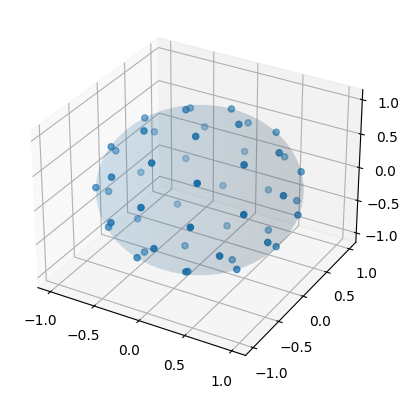

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
ax.plot_surface(np.outer(np.cos(u), np.sin(v)),
                np.outer(np.sin(u), np.sin(v)),
                np.outer(np.ones(np.size(u)), np.cos(v)),
                alpha=.1)

ax.scatter(out[:, 0],
           out[:, 1],
           out[:, 2])

plt.show()